# Lab 3b

## Contents
* [Part 1: Cross validation for parameter tuning, model selection, and feature selection](#Part-1:-Cross-validation-for-parameter-tuning,-model-selection,-and-feature-selection)
* [Part 2: Efficiently searching for optimal tuning parameters](#Part-2:-Efficiently-searching-for-optimal-tuning-parameters)
* [Part 3: Evaluating a classification model](#Part-3:-Evaluating-a-classification-model)
***

## Part 1: Cross-validation for parameter tuning, model selection, and feature selection


### Agenda

- What is the drawback of using the **train/test split** procedure for model evaluation?
- How does **K-fold cross-validation** overcome this limitation?
- How can cross-validation be used for selecting **tuning parameters**, choosing between **models**, and selecting **features**?
- What are some possible **improvements** to cross-validation?

### 1.1 Review of model evaluation procedures

**Motivation:** Need a principled way to choose between machine learning approaches (models, model parameters, features)

- Goal is to estimate likely performance of a model on **out-of-sample data**

**Initial idea:** Train and test on the same data

- But, maximizing **training accuracy** rewards overly complex models which **overfit** the training data

**Alternative idea:** Train/test split

- Split the dataset into two pieces, so that the model can be trained and tested on **different data**
- **Testing accuracy** is a better estimate than training accuracy of out-of-sample performance
- But, it provides a **high variance** estimate since changing which observations happen to be in the testing set can significantly change testing accuracy

In [1]:
# import required modules
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Recall our iris dataset.

In [2]:
# read in the iris data
iris = load_iris()

# create X (features) and y (response)
X = iris.data
y = iris.target

Below we train and test the KNN (k=5) model using 100 different train/test splits.

In [4]:
# use train/test split with different random_state values
# this demonstrates that the accuracy depends on which samples are used to train and test
import numpy as np
scores = []
for rs in range(1,100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=rs)

    # check classification accuracy of KNN with K=5
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))
scores = np.array(scores)    
i = np.argmax(scores)
print('best [k, score] = [%g, %g], mean score = '%(i+1, scores[i]), scores.mean())

best [k, score] = [2, 1], mean score =  0.96049382716


__Task 1:__ Plot a histogram of the measured accuracies.

(array([  8.,   0.,  14.,   0.,   0.,  36.,   0.,  30.,   0.,  11.]),
 array([ 0.91111111,  0.92      ,  0.92888889,  0.93777778,  0.94666667,
         0.95555556,  0.96444444,  0.97333333,  0.98222222,  0.99111111,  1.        ]),
 <a list of 10 Patch objects>)

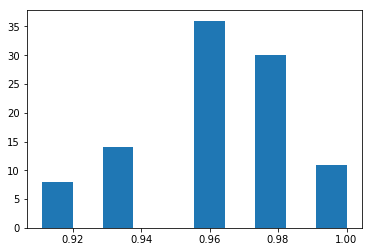

In [8]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(scores)

The histogram above clearly shows that test accuracy depends on the train/test split used.

### K-fold cross-validation

Averaging the results of a number of train/test splits provides a better estimate of a models out-of-sample performance.  K-fold cross-validation provides a recipe for doing this.

**Algorithm:**
1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy.

Diagram of **5-fold cross-validation:**

![5-fold cross-validation](images/07_cross_validation_diagram.png)

`sklean` provides a variety of tools for doing k-fold cross-validation.  Below is an example of `model_selection.Kfold`.  Given the number of splits (i.e. folds) and a feature matrix, this function returns a list of train and test row indices to use with each run of training and testing. 

In [9]:
# simulate splitting a dataset of 15 observations into 5 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False)
splits = kf.split(X[:15])

# print the indices of each training and testing set
print('{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
for iteration, data in enumerate(splits, start=1):
    print('{!r:^9} {} {!r:^25}'.format(iteration, list(data[0]), list(data[1])))

Iteration                   Training set observations                   Testing set observations
    1     [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]         [0, 1, 2]        
    2     [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]         [3, 4, 5]        
    3     [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14]         [6, 7, 8]        
    4     [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14]        [9, 10, 11]       
    5     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]       [12, 13, 14]       


In the `Kfold` example above,
- The feature dataset contains **15 observations** (i.e. rows, numbered 0 through 14)
- `n_splits=5` corresponds to 5-fold cross-validation
- five different sets of train/test indices are produced, appropriate for **5 iterations**
- For each iteration, every observation is either in the training set or the testing set, **but not both**
- Every observation is in the testing set **exactly once**

### 1.3 Comparing cross-validation to train/test split

Advantages of **cross-validation:**

- More accurate estimate of out-of-sample accuracy
 - However order of rows and the value of k affects outcome, i.e. still setup dependent
- More "efficient" use of data (every observation is used for both training and testing)

Advantages of **train/test split:**

- Runs K times faster than K-fold cross-validation
- Simpler to examine the detailed results of the testing process

### 1.4 Cross-validation recommendations

1. K can be any number, but **K=10** is often recommended (YMMV)
2. For classification problems, [stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling) is recommended for creating the folds
    - Each response class should be represented with equal proportions in each of the K folds
    - scikit-learn's `cross_val_score` function, which we discuss below, does this by default

### 1.5 Cross-validation example: parameter tuning

**Goal:** Select the best tuning parameters (aka "hyperparameters") for KNN on the iris dataset using cross-validation

The code below finds mean accuracy for a set of parameters using cross-validation using `model_selection.cross_val_score` 

In [10]:
from sklearn.model_selection import cross_val_score
import numpy as np

In [11]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[ 1.          0.93333333  1.          1.          0.86666667  0.93333333
  0.93333333  1.          1.          1.        ]


In [12]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.966666666667


In [13]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
i = np.argmax(np.array(k_scores))
print('best [k, score] = [%g, %g]'%(k_range[i], k_scores[i]))

best [k, score] = [13, 0.98]


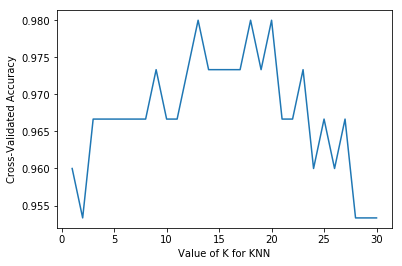

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

### 1.6 Cross-validation example: model selection

**Goal:** Compare the best KNN model with Logistic Regression classifier on the iris dataset

In [ ]:
# 10-fold cross-validation with the best KNN model
knn = KNeighborsClassifier(n_neighbors=13)
print(cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean())

__Task 2:__ Print the mean 10-fold cross validation score of the default Logistic Regression classifier model applied to the iris dataset.  Include a comment as to which model you would select.

In [15]:
# 10-fold cross-validation with logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
print(cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())

0.953333333333


### 1.7 Cross-validation Summary

** Steps for cross-validation: **
- Dataset is split into K "folds" of **equal size**
- Each fold acts as the **testing set** 1 time, and acts as the **training set** K-1 times
- **Average testing performance** is used as the estimate of out-of-sample performance

** Benefits of cross-validation: **
- More **reliable** estimate of out-of-sample performance than train/test split
- Can be used for selecting **tuning parameters**, choosing between **models**, and selecting **features**

** Drawbacks of cross-validation: **

- Can be computationally **expensive**

### 1.8 Cross-validation Improvements

**Repeated cross-validation**
- Repeat cross-validation multiple times (with **different random splits** of the data) and average the results
- More reliable estimate of out-of-sample performance by **reducing the variance** associated with a single trial of cross-validation

**Creating a hold-out set**
- "Hold out" a portion of the data **before** beginning the model building process
- Locate the best model using cross-validation on the remaining data, and test it **using the hold-out set**
- More honest estimate of out-of-sample performance since hold-out set is **truly out-of-sample**, but unless the hold-out set is large enough may not be accurate.

**Feature engineering and selection within cross-validation iterations**

- Normally, feature engineering and selection occurs **before** cross-validation
- Instead, perform all feature engineering and selection **within each cross-validation iteration**
- More reliable estimate of out-of-sample performance since it **better mimics** the application of the model to out-of-sample data

### 1.9 Resources

- scikit-learn documentation: [Cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html), [Model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)
- Section 5.1 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) (11 pages) and related videos: [K-fold and leave-one-out cross-validation](https://www.youtube.com/watch?v=nZAM5OXrktY) (14 minutes), [Cross-validation the right and wrong ways](https://www.youtube.com/watch?v=S06JpVoNaA0) (10 minutes)
- Scott Fortmann-Roe: [Accurately Measuring Model Prediction Error](http://scott.fortmann-roe.com/docs/MeasuringError.html)
- Machine Learning Mastery: [An Introduction to Feature Selection](http://machinelearningmastery.com/an-introduction-to-feature-selection/)
- Harvard CS109: [Cross-Validation: The Right and Wrong Way](https://github.com/cs109/content/blob/master/lec_10_cross_val.ipynb)
- Journal of Cheminformatics: [Cross-validation pitfalls when selecting and assessing regression and classification models](http://www.jcheminf.com/content/pdf/1758-2946-6-10.pdf)

***
## Part 2: Efficiently searching for hyperparameters


### Agenda

- How can K-fold cross-validation be used to search for **good classifier parameters**?
- How can this process be made **more efficient**?
- How do you search for **multiple tuning parameters** at once?
- What do you do with those tuning parameters before making **real predictions**?
- How can the **computational expense** of this process be reduced?

Searching for better sets of parameters using cross validation is such a common task that [sklearn.model_selection](http://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers) provides a number of functions for automating this task.  

### Parameter tuning using `GridSearchCV`

The [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function allows you to define a **grid of parameters** that will exhaustively be **searched** using K-fold cross-validation in order to find the best set of parameters.  Below is an example with a single set of **grid parameters**.

In [41]:
from sklearn.model_selection import GridSearchCV
# create X (features) and y (response)
X = iris.data
y = iris.target

In [42]:
# define the parameter values that should be searched
k_range = list(range(1, 31))
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}


In [43]:
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

- You can set **`n_jobs = -1`** to run computations in parallel (if supported by your computer and OS)

In [44]:
# Run the grid search on the data
grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [20]:
# A complete record the cross validation search results is stored in
# dictionary.  Here it is
grid.cv_results_

{'mean_fit_time': array([ 0.00041754,  0.00034301,  0.00032818,  0.00065224,  0.00037169,
         0.00033414,  0.00028858,  0.00027833,  0.00028088,  0.00028057,
         0.00027852,  0.00027752,  0.00027785,  0.00031524,  0.00029161,
         0.00028808,  0.00027697,  0.0002768 ,  0.00027573,  0.00027609,
         0.00028012,  0.00028164,  0.00028176,  0.00028207,  0.00029092,
         0.00028281,  0.00028226,  0.0002835 ,  0.00029168,  0.0002923 ]),
 'mean_score_time': array([ 0.0006578 ,  0.00064616,  0.00059409,  0.00109591,  0.00060136,
         0.00054569,  0.00049553,  0.00048804,  0.00049436,  0.0004941 ,
         0.00049782,  0.00049317,  0.00049863,  0.00053949,  0.00051432,
         0.00050416,  0.00049858,  0.00050147,  0.00050132,  0.00050058,
         0.00051172,  0.00050905,  0.0005192 ,  0.00051994,  0.0005388 ,
         0.0005192 ,  0.00052011,  0.00053413,  0.00053144,  0.00055201]),
 'mean_test_score': array([ 0.96      ,  0.95333333,  0.96666667,  0.96666667,  0.96

In [45]:
# examine the first run
print(grid.cv_results_['params'][0])
print(grid.cv_results_['mean_test_score'][0])      

{'n_neighbors': 1}
0.96


__Task 3:__ Now that you've seen how to access some the values in cv_results, use them to create a plot of mean test scores and also determine the best set of parameters and its score.

Value of k:  12
Score:  0.98
Value of k:  17
Score:  0.98
Value of k:  19
Score:  0.98


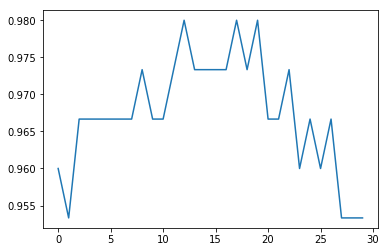

In [52]:
# Implement your solution using array of of the mean test scores, 
# called grid_mean_scores

grid_mean_scores = grid.cv_results_['mean_test_score']

plt.plot(grid_mean_scores)

max_score = max(grid_mean_scores)

for idx, score in enumerate(grid_mean_scores):
    
    if score == max_score:
        print("Value of k: ", idx)
        print("Score: ", score)

# test cases, do not change!
assert len(grid_mean_scores)==30
assert isinstance(grid_mean_scores[0], np.float)


In [53]:
# Finding the set of parameter and associated model is such a common task, 
# it is also stored automatically
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

{'n_neighbors': 13}
0.98
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='uniform')


### 2.4 Searching multiple parameters simultaneously

- **Example:** tuning `max_depth` and `min_samples_leaf` for a `DecisionTreeClassifier`
- Could tune parameters **independently**: change `max_depth` while leaving `min_samples_leaf` at its default value, and vice versa
- But, best performance might be achieved when **neither parameter** is at its default value

In [54]:
# define the parameter values that should be searched
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']

In [55]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}


In [56]:
# instantiate and fit the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [30]:
# view the complete results
grid.cv_results_

{'mean_fit_time': array([ 0.00039551,  0.00037632,  0.00034192,  0.00062742,  0.0003721 ,
         0.00030832,  0.00028064,  0.00028882,  0.00027976,  0.00029042,
         0.00032649,  0.00028231,  0.00027843,  0.0002857 ,  0.0003093 ,
         0.00033607,  0.00027955,  0.00028105,  0.00027902,  0.00028434,
         0.00028274,  0.00028384,  0.00028026,  0.0002795 ,  0.00027974,
         0.00028381,  0.00028214,  0.00028324,  0.00028038,  0.0002804 ,
         0.00028217,  0.00028226,  0.00028524,  0.00029233,  0.00029371,
         0.00028236,  0.00028334,  0.00028305,  0.00028391,  0.00029297,
         0.00039508,  0.00040758,  0.0003787 ,  0.0003778 ,  0.00036666,
         0.00035651,  0.00028694,  0.00035415,  0.00031667,  0.00032063,
         0.00028551,  0.00028806,  0.0002852 ,  0.0002866 ,  0.00030935,
         0.00028701,  0.00028217,  0.00028305,  0.00028317,  0.00028627]),
 'mean_score_time': array([ 0.00063286,  0.00061998,  0.00057681,  0.00116179,  0.0006464 ,
         0.00

In [31]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.98
{'n_neighbors': 13, 'weights': 'uniform'}


### 2.5 Using the best parameters to make predictions
Once you've found the best set of parameters using cross-validation you should retrain your model using all the data. See below.

In [32]:
# train your model using all data and the best known parameters
knn = KNeighborsClassifier(n_neighbors=13, weights='uniform')
knn.fit(X, y)

# make a prediction on out-of-sample data
knn.predict([[3, 5, 4, 2]])

array([1])

In [33]:
# shortcut: GridSearchCV automatically refits the best model using all of the data
grid.predict([[3, 5, 4, 2]])

array([1])

### 2.6 Reducing computational expense using `RandomizedSearchCV`

- Searching many different sets of parameters at once may be computationally infeasible
- `RandomizedSearchCV` searches a subset of the parameters, and you control the computational "budget"

In [34]:
from sklearn.grid_search import RandomizedSearchCV

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [57]:
# specify "parameter distributions" rather than a "parameter grid"
param_dist = dict(n_neighbors=k_range, weights=weight_options)

- **Important:** Specify a continuous distribution (rather than a list of values) for any continous parameters

In [58]:
# n_iter controls the number of searches
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
rand.fit(X, y)
rand.grid_scores_

[mean: 0.97333, std: 0.03266, params: {'weights': 'distance', 'n_neighbors': 16},
 mean: 0.96667, std: 0.03333, params: {'weights': 'uniform', 'n_neighbors': 22},
 mean: 0.98000, std: 0.03055, params: {'weights': 'uniform', 'n_neighbors': 18},
 mean: 0.96667, std: 0.04472, params: {'weights': 'uniform', 'n_neighbors': 27},
 mean: 0.95333, std: 0.04269, params: {'weights': 'uniform', 'n_neighbors': 29},
 mean: 0.97333, std: 0.03266, params: {'weights': 'distance', 'n_neighbors': 10},
 mean: 0.96667, std: 0.04472, params: {'weights': 'distance', 'n_neighbors': 22},
 mean: 0.97333, std: 0.04422, params: {'weights': 'uniform', 'n_neighbors': 14},
 mean: 0.97333, std: 0.04422, params: {'weights': 'distance', 'n_neighbors': 12},
 mean: 0.97333, std: 0.03266, params: {'weights': 'uniform', 'n_neighbors': 15}]

In [38]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.98
{'weights': 'uniform', 'n_neighbors': 18}


In [63]:
# run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
best_scores = []
params = []
for _ in range(20):
    rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', n_iter=10)
    rand.fit(X, y)
    best_scores.append(round(rand.best_score_, 3))
    params.append(rand.best_params_)
    
print(best_scores)
print(params)


[0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.973, 0.98, 0.98, 0.98, 0.98, 0.973, 0.98, 0.973, 0.98, 0.973, 0.98, 0.98, 0.98, 0.973]
[{'weights': 'uniform', 'n_neighbors': 18}, {'weights': 'distance', 'n_neighbors': 17}, {'weights': 'uniform', 'n_neighbors': 13}, {'weights': 'uniform', 'n_neighbors': 18}, {'weights': 'distance', 'n_neighbors': 27}, {'weights': 'uniform', 'n_neighbors': 13}, {'weights': 'distance', 'n_neighbors': 12}, {'weights': 'distance', 'n_neighbors': 27}, {'weights': 'distance', 'n_neighbors': 15}, {'weights': 'uniform', 'n_neighbors': 13}, {'weights': 'distance', 'n_neighbors': 17}, {'weights': 'distance', 'n_neighbors': 29}, {'weights': 'uniform', 'n_neighbors': 13}, {'weights': 'distance', 'n_neighbors': 10}, {'weights': 'distance', 'n_neighbors': 19}, {'weights': 'distance', 'n_neighbors': 24}, {'weights': 'distance', 'n_neighbors': 19}, {'weights': 'uniform', 'n_neighbors': 13}, {'weights': 'uniform', 'n_neighbors': 13}, {'weights': 'uniform', 'n_neighbors': 16}]


### 2.7 Resources

- scikit-learn documentation: [Grid search](http://scikit-learn.org/stable/modules/grid_search.html), [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html), [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html)
- Timed example: [Comparing randomized search and grid search](http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html)
- scikit-learn workshop by Andreas Mueller: [Video segment on randomized search](https://youtu.be/0wUF_Ov8b0A?t=17m38s) (3 minutes), [related notebook](https://github.com/amueller/pydata-nyc-advanced-sklearn/blob/master/Chapter%203%20-%20Randomized%20Hyper%20Parameter%20Search.ipynb)
- Paper by Yoshua Bengio: [Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)

***
## Part 3: Evaluating classifier performance, I

### Agenda

- What is the purpose of **model evaluation**, and what are some common evaluation procedures?
- What is the usage of **classification accuracy**, and what are its limitations?
- How does a **confusion matrix** describe the performance of a classifier?
- What **metrics** can be computed from a confusion matrix?

### 3.1 Review of model evaluation

- Need a way to choose between models: different model types, tuning parameters, and features
- Use a **model evaluation procedure** to estimate how well a model will generalize to out-of-sample data
- Requires a **model evaluation metric** to quantify the model performance

### Model evaluation procedures

1. **Training and testing on the same data**
    - Rewards overly complex models that "overfit" the training data and won't necessarily generalize
2. **Train/test split**
    - Split the dataset into two pieces, so that the model can be trained and tested on different data
    - Better estimate of out-of-sample performance, but still a "high variance" estimate
    - Useful due to its speed, simplicity, and flexibility
3. **K-fold cross-validation**
    - Systematically create "K" train/test splits and average the results together
    - Even better estimate of out-of-sample performance
    - Runs "K" times slower than train/test split

### Model evaluation metrics

- **Regression problems:** Mean Absolute Error, Mean Squared Error, Root Mean Squared Error
- **Classification problems:** Classification accuracy

### 3.2 Classification accuracy

[Pima Indian Diabetes dataset](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes) from the UCI Machine Learning Repository

In [64]:
# read the data into a Pandas DataFrame
import pandas as pd
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
pima = pd.read_csv(url, header=None, names=col_names)

In [65]:
# print the first 5 rows of data
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Question:** Can we predict the diabetes status of a patient given their health measurements?

In [66]:
# define X and y
feature_cols = ['pregnant', 'insulin', 'bmi', 'age']
X = pima[feature_cols]
y = pima.label

In [67]:
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [68]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [69]:
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

**Classification accuracy:** percentage of correct predictions

In [70]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.692708333333


**Null accuracy:** accuracy that could be achieved by always predicting the most frequent class

In [71]:
# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

0    130
1     62
Name: label, dtype: int64

In [72]:
# calculate the percentage of ones
y_test.mean()

0.3229166666666667

In [73]:
# calculate the percentage of zeros
1 - y_test.mean()

0.6770833333333333

In [74]:
# calculate null accuracy (for binary classification problems coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

0.6770833333333333

In [75]:
# calculate null accuracy (for multi-class classification problems)
y_test.value_counts().head(1) / len(y_test)

0    0.677083
Name: label, dtype: float64

Comparing the **true** and **predicted** response values

In [76]:
# print the first 25 true and predicted responses
from __future__ import print_function
print('True:', y_test.values[0:25])
print('Pred:', y_pred_class[0:25])

True: [1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0]
Pred: [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


**Conclusion:**

- Classification accuracy is the **easiest classification metric to understand**
- But, it does not tell you the **underlying distribution** of response values
- And, it does not tell you what **"types" of errors** your classifier is making

### 3.3 Confusion matrix

Table that describes the performance of a classification model

In [77]:
# IMPORTANT: first argument is true values, second argument is predicted values
print(metrics.confusion_matrix(y_test, y_pred_class))

[[118  12]
 [ 47  15]]


![Small confusion matrix](images/09_confusion_matrix_1.png)

- Every observation in the testing set is represented in **exactly one box**
- It's a 2x2 matrix because there are **2 response classes**
- The format shown here is **not** universal

**Basic terminology**

- **True Positives (TP):** we *correctly* predicted that they *do* have diabetes
- **True Negatives (TN):** we *correctly* predicted that they *don't* have diabetes
- **False Positives (FP):** we *incorrectly* predicted that they *do* have diabetes (a "Type I error")
- **False Negatives (FN):** we *incorrectly* predicted that they *don't* have diabetes (a "Type II error")

In [78]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:25])
print('Pred:', y_pred_class[0:25])

True: [1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0]
Pred: [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [80]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print(TP)

15


![Large confusion matrix](images/09_confusion_matrix_2.png)

### 3.4 Metrics computed from a confusion matrix

**Classification Accuracy:** Overall, how often is the classifier correct?

In [81]:
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.692708333333
0.692708333333


**Classification Error:** Overall, how often is the classifier incorrect?

- Also known as "Misclassification Rate"

In [82]:
print((FP + FN) / float(TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.307291666667
0.307291666667


**Sensitivity:** When the actual value is positive, how often is the prediction correct?

- How "sensitive" is the classifier to detecting positive instances?
- Also known as "True Positive Rate" or "Recall"

In [83]:
print(TP / float(TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

0.241935483871
0.241935483871


**Specificity:** When the actual value is negative, how often is the prediction correct?

- How "specific" (or "selective") is the classifier in predicting positive instances?

In [84]:
print(TN / float(TN + FP))

0.907692307692


**False Positive Rate:** When the actual value is negative, how often is the prediction incorrect?

In [85]:
print(FP / float(TN + FP))

0.0923076923077


**Precision:** When a positive value is predicted, how often is the prediction correct?

- How "precise" is the classifier when predicting positive instances?

In [86]:
print(TP / float(TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

0.555555555556
0.555555555556


Many other metrics can be computed: F1 score, Matthews correlation coefficient, etc.

**Conclusion:**

- Confusion matrix gives you a **more complete picture** of how your classifier is performing
- Also allows you to compute various **classification metrics**, and these metrics can guide your model selection

**Which metrics should you focus on?**

- Choice of metric depends on your **business objective**
- **Spam filter** (positive class is "spam"): Optimize for **precision or specificity** because false negatives (spam goes to the inbox) are more acceptable than false positives (non-spam is caught by the spam filter)
- **Fraudulent transaction detector** (positive class is "fraud"): Optimize for **sensitivity** because false positives (normal transactions that are flagged as possible fraud) are more acceptable than false negatives (fraudulent transactions that are not detected)